In [20]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [24]:
#Reading the file in which the values are saved, converting the Date into a panda Datetime format
appa_hours = pd.read_csv("../exports/appa_hr_age.csv")
appa_hours.Time = pd.to_datetime(appa_hours.Time)

In [25]:
#Converting the hour, day, week, month and year into a sin/cos function to gain the cyclicity of the values
appa_hours["sin_hour"] = appa_hours["Time"].dt.hour.apply(
    lambda x: math.sin(x) * 2 * (math.pi / 24)
)
appa_hours["cos_hour"] = appa_hours["Time"].dt.hour.apply(
    lambda x: math.cos(x) * 2 * (math.pi / 24)
)

appa_hours["sin_weekday"] = appa_hours["Time"].dt.weekday.apply(
    lambda x: math.sin(x) * 2 * (math.pi / 7)
)
appa_hours["cos_weekday"] = appa_hours["Time"].dt.weekday.apply(
    lambda x: math.cos(x) * 2 * (math.pi / 7)
)

appa_hours["sin_month"] = appa_hours["Time"].dt.month.apply(
    lambda x: math.sin(x) * 2 * (math.pi / 12)
)

appa_hours["cos_month"] = appa_hours["Time"].dt.month.apply(
    lambda x: math.cos(x) * 2 * (math.pi / 12)
)

appa_hours["sin_ordate"] = appa_hours["Time"].apply(
    lambda x: math.sin(x.toordinal()) * 2 * (math.pi / 366)
)
appa_hours["cos_ordate"] = appa_hours["Time"].apply(
    lambda x: math.cos(x.toordinal()) * 2 * (math.pi / 366)
)

appa_hours["year"] = appa_hours["Time"].dt.year

In [26]:
#selecting all the values we need to train and test the model
appa_hours = appa_hours[[
    'ZnOR_1', 'ZnOR_2',
    'LaFeO3_1', 'LaFeO3_2',
    'WO3_1', 'WO3_2',
    'ZnOR_1_heatR', 'ZnOR_2_heatR',
    'LaFeO3_1_heatR', 'LaFeO3_2_heatR',
    'WO3_1_heatR', 'WO3_2_heatR',
    'ZnOR_1_heatV', 'ZnOR_2_heatV',
    'LaFeO3_1_heatV', 'LaFeO3_2_heatV',
    'WO3_1_heatV', 'WO3_2_heatV',
    'Temperature', 'Relative_Humidity', 'Pressure', 'VOC',
    'ZnOR_1_Age', 'ZnOR_2_Age',
    'LaFeO3_1_Age', 'LaFeO3_2_Age',
    'WO3_1_Age', 'WO3_2_Age',
    'sin_hour', 'cos_hour',
    'sin_weekday', 'cos_weekday',
    'sin_month', 'cos_month',
    'sin_ordate', 'cos_ordate',
    'year',
    'NO2', 'SO2', 'O3', 'CO'
]]

# Random Forest

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [28]:
#Selecting the features
cols = [
    'ZnOR_1', 'ZnOR_2',
    'LaFeO3_1', 'LaFeO3_2',
    'WO3_1', 'WO3_2',
    'ZnOR_1_heatR', 'ZnOR_2_heatR',
    'LaFeO3_1_heatR', 'LaFeO3_2_heatR',
    'WO3_1_heatR', 'WO3_2_heatR',
    'ZnOR_1_heatV', 'ZnOR_2_heatV',
    'LaFeO3_1_heatV', 'LaFeO3_2_heatV',
    'WO3_1_heatV', 'WO3_2_heatV',
    'Temperature', 'Relative_Humidity', 'Pressure', 'VOC',
    'ZnOR_1_Age', 'ZnOR_2_Age',
    'LaFeO3_1_Age', 'LaFeO3_2_Age',
    'WO3_1_Age', 'WO3_2_Age',
    'sin_hour', 'cos_hour',
    'sin_weekday', 'cos_weekday',
    'sin_month', 'cos_month',
    'sin_ordate', 'cos_ordate',
    'year'
]

#Selecting the target
outs = ['NO2', 'O3', 'CO']

In [29]:
from sklearn.model_selection import train_test_split

#splitting the values in training and test
vsplit = round(len(appa_hours) * 0.2)

X_train = appa_hours.iloc[vsplit:][cols]
X_test = appa_hours.iloc[:vsplit][cols]

Y_train = appa_hours.iloc[vsplit:][outs]
Y_test = appa_hours.iloc[:vsplit][outs]


In [8]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': ['sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [9]:
# Choosing the type of model
model = RandomForestRegressor()

In [10]:
# Performing the RandomForestRegression with a Random Search on hyper-parameters
rf_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=100, cv=3, verbose=2,
                               random_state=42, n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, verbose=2)

In [23]:
#Creating a Dataframe with the results of the model and then saving them into a .csv file
ris = pd.DataFrame(rf_random.cv_results_)
ris.to_csv('risultati.csv')

In [45]:
#Saving the model itself in a .sav file
import pickle
pickle.dump(rf_random, open('model/random_forest_gridsearch.sav', 'wb'))

## Results

In [ ]:
#A method to print the performance of the model
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print(f'Average Degrees Error:\n{np.mean(errors)}')
    print(f'Accuracy:\n{accuracy}')
    return accuracy

In [ ]:
base_accuracy = evaluate(rf_random, X_test, Y_test)

## Hyper Parameters Plots

C:\Users\londe\AppData\Local\Temp\ipykernel_12420\2667864387.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


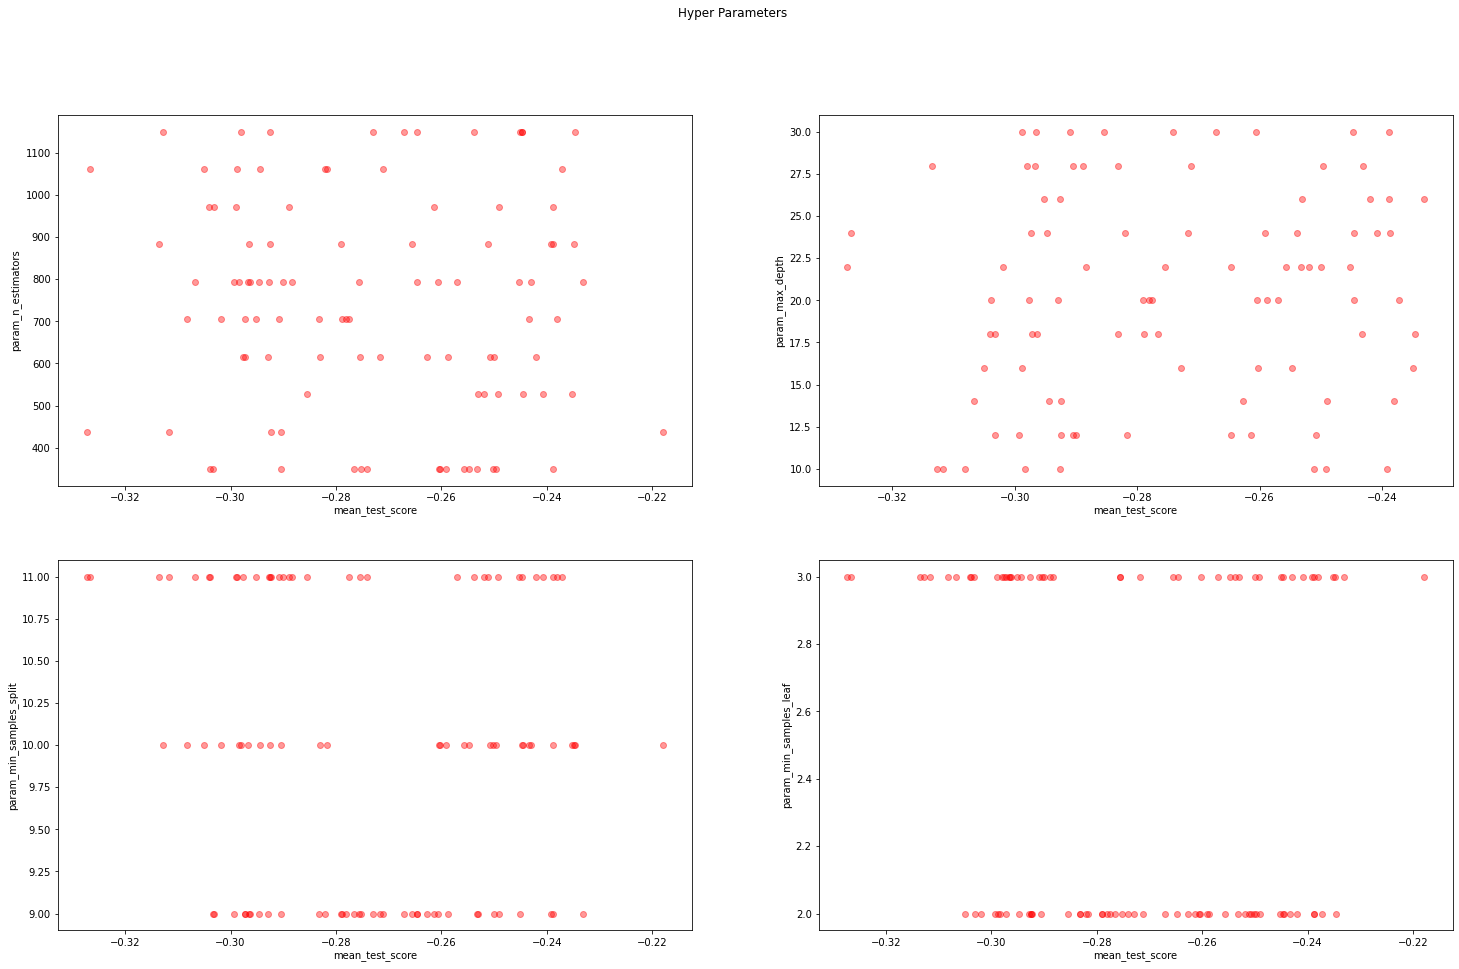

In [18]:
#Plotting the hyper-parameters in relation of mean test score
#Values are plotted through dots. The brighter the dot, the more times that value has been chosen by the models.
#On the X scale, the closer the values are to 0 the better they are

h_params = ['param_n_estimators', 'param_max_depth' , 'param_min_samples_split', 'param_min_samples_leaf']
fig = plt.figure(figsize=(25, 15))
fig.suptitle('Hyper Parameters')
outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)
for index, h_param in enumerate(h_params):
    ax = plt.Subplot(fig, outer[index])
    ax.scatter(ris['mean_test_score'], ris[h_param],color='red', alpha=0.4, )
    ax.set_ylabel(h_param)
    ax.set_xlabel('mean_test_score')
    fig.add_subplot(ax)
fig.show()

## Feature Importance

NameError: name 'rf_random' is not defined

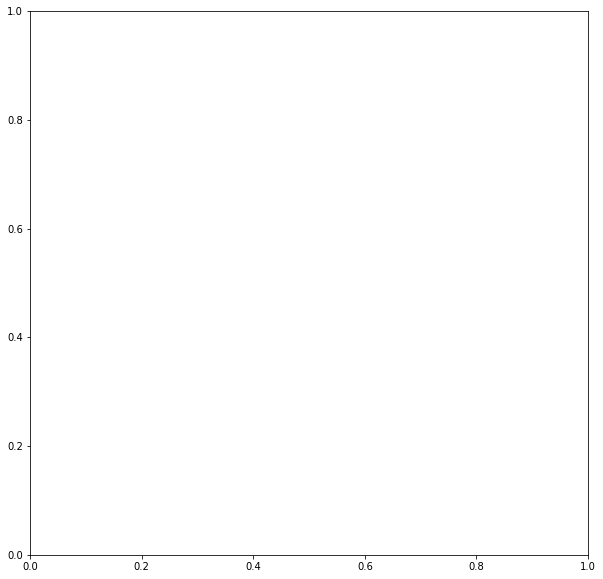

In [30]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.barh(X_test.columns, rf_random.best_estimator_.feature_importances_)
plt.show()